<a href="https://colab.research.google.com/github/Falconwatch/nes_bs_proj/blob/main/Business_stats_project_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("rahulvyasm/medical-insurance-cost-prediction")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, normaltest, probplot
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import linear_reset

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
data = pd.read_csv("/root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1/medical_insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Motivation
Aim of this study is to investigate gow insurance companies prices their products. We want to understand what factors determine price. Find out if there is any descrimination. Indirectly - find out which indicators are RSI factors, since insurance companies include them in pricing.

Data from: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction/data

# Data dictionary

|codename|meaning|data type|categories / measurement|
|---|---|---|---|
|Age      |Age of policyholder|Numerical  |full years    |
|Sex      |Sex of policyholder|Categorical|female or male|
|BMI      |Body Mass Index -  a value derived from the mass (weight) and height of a person. <br> The BMI is defined as the body mass divided by the square of the body height.|Numerical|kg/m^2|
|Children |Number of children           |Numerical|person   |
|Smoker   |Flag if policyholder smokes  |Categorical|yes, no   |
|Region   |Region of policyholder living|Categorical|southeast, southwest, northeast, northwest|
|Charges  |Price of insurance - target  |Numerical |dollar|

In [4]:
numerical_feats = ["age", "bmi", "children"]
categorical_feats = ["sex", "smoker", "region"]
target = "charges"

# Data description (EDA)

## Numerical

In [5]:
def describe_numerical(df, column):
  desciption = {}
  desciption["mean"] = df[column].mean()
  desciption["median"] = df[column].median()
  desciption["min"] = df[column].min()
  desciption["max"] = df[column].max()
  desciption["na_counts"] = data["age"].isna().sum()
  return desciption
pd.DataFrame({nf:describe_numerical(data, nf) for nf in numerical_feats})

,age,bmi,children
mean,39.109668,30.701349,1.101732
median,39.000000,30.447500,1.000000
min,18.000000,15.960000,0.000000
max,64.000000,53.130000,5.000000
na_counts,0.000000,0.000000,0.000000


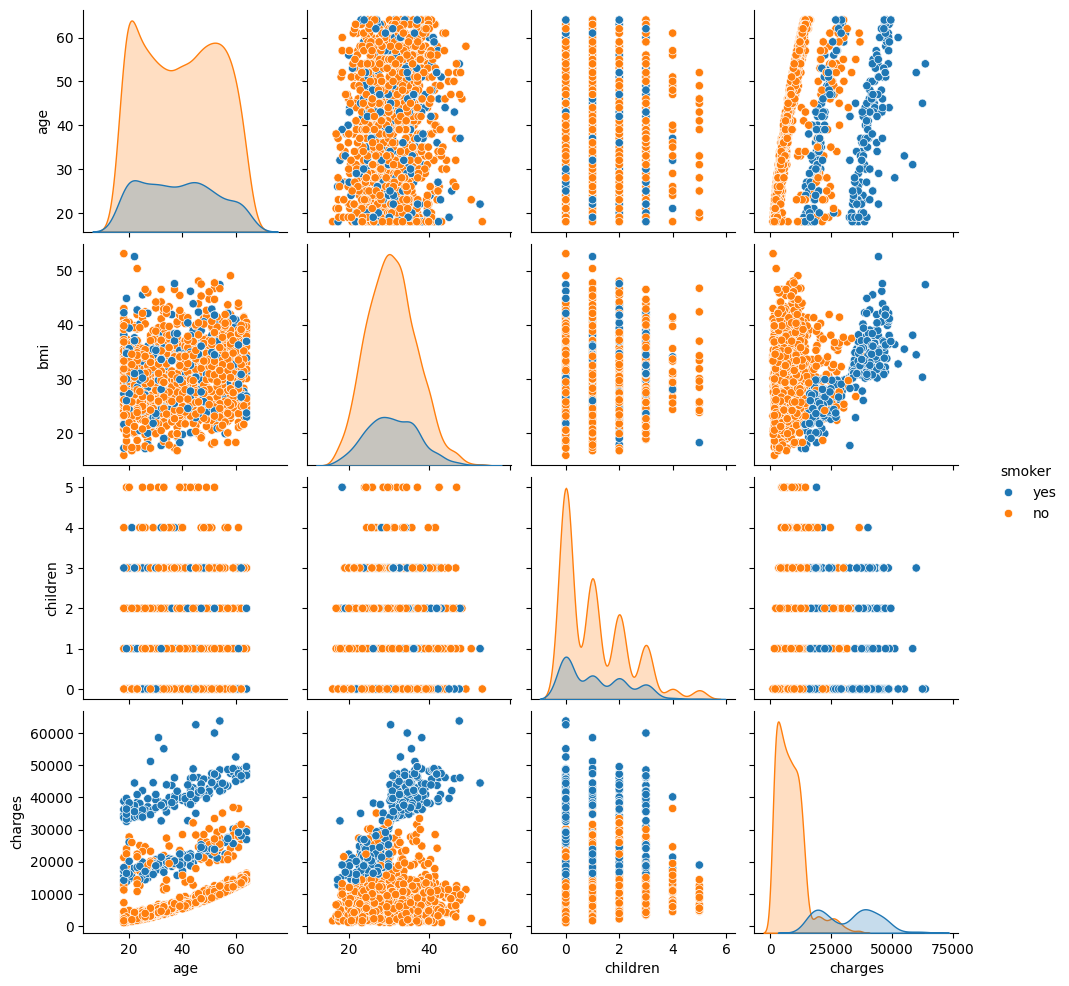

In [6]:
sns.pairplot(data[numerical_feats+["smoker", target]], hue="smoker")

In [ ]:
sns.pairplot(data[numerical_feats+["sex", target]], hue="sex")

### Normality

In [ ]:
def test_normality(column):
    stat_shapiro, p_shapiro = shapiro(data[column])
    stat_dagostino, p_dagostino = normaltest(data[column])
    print(f"Normality Tests for {column}:")
    print(f"Shapiro-Wilk Test: p-value = {p_shapiro:.4f}")
    print(f"D'Agostino’s K-squared Test: p-value = {p_dagostino:.4f}\n")

for col in numerical_feats:
    test_normality(col)

Shapiro-Wilk Test and D'Agostino’s K-squared Test both produce p-values = 0.0000.

Since p-values are below the significance level (0.05), we reject the null hypothesis that these variables follow a normal distribution. All tested variables are not normally distributed, which could impact regression assumptions and analysis.

## Categorical

## Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[numerical_feats].copy()
X.loc[:, 'intercept'] = 1
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

### Distribution

In [ ]:
fix, axes = plt.subplots(1, len(categorical_feats), figsize=[15,4])
sns.set_style("whitegrid")
for i in range(len(categorical_feats)):
  cf_info = data[categorical_feats[i]].value_counts(ascending=False)
  axes[i].pie(cf_info.values, labels=cf_info.index, autopct='%1.1f%%')
  axes[i].set_title(categorical_feats[i])


### Cross-dependecies

In [ ]:
sns.violinplot(data, x="region", y="charges", split="sex", hue="sex")

In [ ]:
sns.violinplot(data, x="region", y="charges", split="smoker", hue="smoker")

In [ ]:
sns.violinplot(data, x="sex", y="charges", split="smoker", hue="smoker")

# Regression analysis

## One factor

### Numeric

In [ ]:
for nf in numerical_feats:
  result_nf = smf.ols(formula="charges~"+nf, data=data).fit()
  print(result_nf.summary())
  print()
  print("##############################################################################")

### Categorical

In [ ]:
for cf in categorical_feats:
  result_cf = smf.ols(formula=f"charges~C({cf})", data=data).fit()
  t = result_cf.summary()
  print("##############################################################################")
  print(cf)
  print(t.tables[1])
  print()


## BaseLine

In [ ]:
def eval_model(model, dataset):
  redictions = result.predict(dataset)
  r2 = r2_score(y_true = dataset["charges"], y_pred=redictions)
  mae = mean_absolute_error(y_true = dataset["charges"], y_pred=redictions)
  return {"r2":r2, "mae":mae}

In [ ]:
train, test = train_test_split(data)

In [ ]:
model = smf.ols(formula="charges~age+bmi+children+C(smoker)+C(sex)", data=train).fit()
print(model.summary())

In [ ]:
print(eval_model(model, train))
print(eval_model(model, test))

### BaseLine 2

In [ ]:
model_2 = smf.ols(formula="charges~age+bmi+children+C(smoker) * C(region)", data=data).fit()
print(model_2.summary())

Идеи что добавить
1.   Тесты на нормальность переменных
2.   тест на гетероскедастичность
3.   тест на мультиколлинераность фичей (VIF)
4.   автокорреляция остатков
5.   qq-plot
6.   Отбор переменных

## Model examination

### Multicollinearity

In [ ]:
data[numerical_feats].corr()

Implications for the Model:

Linear regression assumes normality of residuals, not necessarily predictors. Skewed predictors (like age) can affect the model fit and outliers.

In [ ]:
data['log_bmi'] = np.log(data['bmi'])

from scipy.stats import shapiro, normaltest

stat_shapiro, p_shapiro = shapiro(data['log_bmi'])
print(f"Log(BMI) Shapiro-Wilk p-value: {p_shapiro:.4f}")

Even after applying the log transformation, log(charges) still does not follow a normal distribution.

In [ ]:
sm.qqplot(model_2.resid, line="45", fit=True)
plt.title("Q-Q Plot for Residuals")
plt.show()

print("")

sns.histplot(model_2.resid, kde=True)
plt.title("Histogram of Residuals")
plt.show()

The Q-Q plot shows the following key observations:

Deviations at the tails:

The residuals deviate significantly from the red 45-degree line at both the lower (left) and upper (right) tails. This indicates the presence of heavy tails or outliers.

S-Curve Shape:

The residuals curve away from the red line in the middle range as well, suggesting non-normality of residuals.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[numerical_feats].copy()
X.loc[:, 'intercept'] = 1
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

The Variance Inflation Factor (VIF) helps identify multicollinearity issues among predictors.

Variable VIF

*   age 1.014
*   bmi 1.012
*   children 1.001
*   intercept 31.741

Predictors (age, bmi, children): All have VIF values close to 1. This indicates that multicollinearity is not a problem in the model.

Intercept: A high VIF for the intercept is normal and not an issue. The intercept represents a constant term, which often has inflated VIF because it does not interact with predictors.

All in all, there is no multicollinearity among the independent variables, so the model estimates for age, bmi, and children are stable and reliable.

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

_, pval, _, _ = het_breuschpagan(model_2.resid, model_2.model.exog)
print(f"P-value for Breusch-Pagan Test: {pval:.4f}")

if pval < 0.05:
    print("Heteroskedasticity is present (residuals have non-constant variance).")
else:
    print("No heteroskedasticity detected (constant variance of residuals).")

Interpretation of Breusch-Pagan Test Results P-value = 0.0000: The null hypothesis of homoskedasticity (constant variance of residuals) is rejected. There is heteroskedasticity present, meaning the variance of residuals is not constant across observations.

Implications

Heteroskedasticity violates one of the key assumptions of linear regression:

It leads to biased standard errors, which in turn affect the significance of coefficients (p-values).
Coefficient estimates remain unbiased, but confidence intervals and t-tests may be unreliable.

In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model_2.resid)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

if dw_stat < 1.5:
    print("Positive autocorrelation detected.")
elif dw_stat > 2.5:
    print("Negative autocorrelation detected.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson Statistic = 2.0826: This value is very close to 2, which indicates that there is no significant autocorrelation in the residuals.

The residuals are not correlated with each other, satisfying one of the key assumptions of linear regression.

This result suggests that the model does not suffer from autocorrelation, and the residuals behave as expected.

In [ ]:
print(model_2.summary())

significant_features = model_2.pvalues[model_2.pvalues < 0.05].index
print(f"Significant Features: {list(significant_features)}")

The significant features in the model are:

Intercept
*   C(smoker)[T.yes] → Being a smoker
significantly increases insurance charges.
*   C(region)[T.southeast] → Southeast region has a significant negative effect on charges.
*   C(region)[T.southwest] → Southwest region also has a significant negative effect.
*   C(smoker)[T.yes]:C(region)[T.southeast] → Interaction between smoker status and southeast region is significant.
*   C(smoker)[T.yes]:C(region)[T.southwest] → Interaction between smoker status and southwest region is significant.
*   age → Age significantly increases charges.
*   bmi → Higher BMI significantly increases charges.
*   children → Number of children has a positive, significant effect.

In [ ]:
def backward_selection(data, target, significance_level=0.05, max_iterations=100):
    data_copy = data.copy()
    features = list(data_copy.columns.drop(target))
    formula = f"{target} ~ {' + '.join(features)}"
    print(f"Initial formula: {formula}\n")

    iteration = 0
    while iteration < max_iterations:
        print(f"--- Iteration {iteration + 1} ---")
        print(f"Current formula: {formula}")
        model = smf.ols(formula, data=data_copy).fit()
        pvalues = model.pvalues.drop("Intercept", errors="ignore")
        max_pval = pvalues.max()

        if max_pval >= significance_level:
            excluded_feature = pvalues.idxmax()
            print(f"Removing: {excluded_feature} (p-value = {max_pval:.4f})")
            if excluded_feature in features:
                features.remove(excluded_feature)
            formula = f"{target} ~ {' + '.join(features)}"
        else:
            print("\nNo more features to remove. Final formula:")
            print(formula)
            break

        iteration += 1

    if iteration == max_iterations:
        print("\nMax iterations reached. Check for potential issues.")

    print("\nBackward selection complete.")
    return model, features

print("Original Model (before backward selection):\n")
result = smf.ols(formula="charges ~ age + bmi + children + C(smoker) * C(region)", data=data).fit()
print(result.summary())

target = "charges"
selected_model, selected_features = backward_selection(data, target)

print("\nOriginal Model Summary:")
print(result.summary())

print("\nNew Model Summary (After Backward Selection):")
print(selected_model.summary())

Original Model (Before Backward Selection):

*   R² = 0.759, Adj. R² = 0.758: The model
explains 75.9% of the variance in charges.
*   Significant variables (p-value < 0.05): C(smoker)[T.yes], C(region)[T.southeast], C(region)[T.southwest], age, bmi, and children.
*   Insignificant variables (p-value > 0.05): C(region)[T.northwest] and C(smoker)[T.yes]:C(region)[T.northwest] do not contribute to the model.
*   Conclusion: The model includes irrelevant variables that add little explanatory power.

New Model (After Backward Selection):

*   R² = 0.884, Adj. R² = 0.884: The new model explains 88.4% of the variance, showing better performance.
*   Significant variables (p-value < 0.05): sex[T.male], smoker[T.yes], region[T.southeast], age, bmi, children, and log_charges.
*   Insignificant variables (p-value > 0.05): region[T.northwest] and region[T.southwest] remain insignificant.
*   Conclusion: The new model is more concise, with only significant predictors, and provides higher explanatory power.